# **GAN Assignment 3**

### **PRN:** 22070126062
### **Name:** Manan Tandel
### **Class:** TY AIML A3  

##### **Problem Statement:** The goal of this assignment is to implement a Deep Convolutional Generative Adversarial Network (DCGAN) as described in the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" by Radford et al. (2015). 

GITHUB LINK: GITHUB_REPO_GAN_ASSIGNMENT_3

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
workers = 2  # Number of subprocesses to use for data loading (Dataloader workers)
batch_size = 128  # Number of images per batch during training
image_size = 64  # Target spatial size of training images (resized using a transformer)
nc = 3  # Number of color channels in input images (3 for RGB, 1 for grayscale)
nz = 100  # Dimensionality of the latent vector (input to the generator)
ngf = 64  # Number of feature maps in the generator (controls generator capacity)
ndf = 64  # Number of feature maps in the discriminator (controls discriminator capacity)
num_epochs = 10  # Total number of training epochs (iterations over the dataset)
lr = 0.0002  # Learning rate for Adam optimizer (controls step size during optimization)
beta1 = 0.5  # Beta1 parameter for Adam optimizer (controls momentum-like behavior)
ngpu = 1  # Number of GPUs available for training (set to 0 for CPU-only execution)


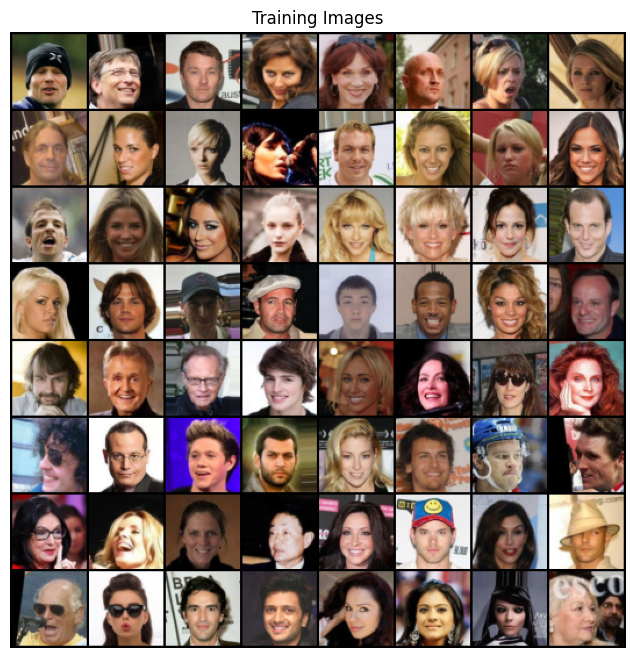

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Define the correct path to the dataset (update if necessary)
dataroot = "/kaggle/input/celeba/img_align_celeba"

# Define transformations to preprocess images before feeding them into the model
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to the specified size
    transforms.CenterCrop(image_size),  # Crop the center to maintain aspect ratio
    transforms.ToTensor(),  # Convert image to a PyTorch tensor (C, H, W) format
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to range [-1, 1]
])

class CelebADataset(Dataset):
    """
    Custom dataset class for loading CelebA images.

    Attributes:
        root_dir (str): Path to the dataset directory containing images.
        transform (callable, optional): Optional transform to apply to images.
        image_filenames (list): Sorted list of all image filenames in the dataset.
    """
    
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset by setting the directory and transformation.

        Args:
            root_dir (str): Directory where images are stored.
            transform (callable, optional): Transformations to apply on images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(root_dir))  # Ensure consistent ordering

    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
            int: Number of images.
        """
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Retrieves an image and applies transformations.

        Args:
            idx (int): Index of the image in the dataset.

        Returns:
            torch.Tensor: Transformed image.
        """
        img_path = os.path.join(self.root_dir, self.image_filenames[idx])  # Get image path
        image = Image.open(img_path).convert("RGB")  # Open the image and convert to RGB
        if self.transform:
            image = self.transform(image)  # Apply transformations
        return image

# Create dataset and dataloader for training
dataset = CelebADataset(root_dir=dataroot, transform=transform)

dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

# Fetch a batch of real images from the dataloader to visualize
real_batch = next(iter(dataloader))

# Display a batch of training images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")

# Convert tensor images to a grid and display
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()


In [ ]:
def weights_init(m):
    """
    Custom weight initialization function for the generator (netG) 
    and discriminator (netD) in a GAN.

    This function initializes:
    - Convolutional layers with a normal distribution (mean=0.0, std=0.02).
    - Batch normalization layers with a normal distribution for weights 
      (mean=1.0, std=0.02) and biases set to zero.

    Args:
        m (torch.nn.Module): A neural network layer.

    Example:
        netG.apply(weights_init)  # Apply to the generator network
        netD.apply(weights_init)  # Apply to the discriminator network
    """
    
    # Get the class name of the layer
    classname = m.__class__.__name__
    
    # Apply initialization for convolutional layers
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # Initialize weights from N(0, 0.02)
    
    # Apply initialization for batch normalization layers
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)  # Initialize weights from N(1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)  # Set bias to zero


In [ ]:
class Generator(nn.Module):
    """
    Generator network for a DCGAN (Deep Convolutional GAN).

    This network takes a random latent vector (Z) and generates a synthetic image 
    using a series of transposed convolutional layers (also known as deconvolutions). 
    The model progressively upsamples the input from a small spatial size to the 
    target image size (64x64).

    Args:
        ngpu (int): Number of GPUs available for training. If greater than 1, 
                    the model supports multi-GPU training.

    Attributes:
        main (nn.Sequential): The generator network consisting of transposed 
                              convolutional layers with batch normalization and ReLU activations.
    """
    
    def __init__(self, ngpu):
        """
        Initializes the Generator model with a series of transposed convolutions.

        Args:
            ngpu (int): Number of GPUs to use for training.
        """
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            # Input: latent vector Z -> (nz x 1 x 1), expanding to feature maps
            
            # First transposed convolution (upsampling from 1x1 to 4x4)
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Output size: (ngf*8) x 4 x 4

            # Second transposed convolution (upsampling from 4x4 to 8x8)
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Output size: (ngf*4) x 8 x 8

            # Third transposed convolution (upsampling from 8x8 to 16x16)
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Output size: (ngf*2) x 16 x 16

            # Fourth transposed convolution (upsampling from 16x16 to 32x32)
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Output size: (ngf) x 32 x 32

            # Final transposed convolution (upsampling from 32x32 to 64x64)
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output range [-1, 1] for normalized image generation
            # Output size: (nc) x 64 x 64
        )

    def forward(self, input):
        """
        Defines the forward pass of the generator.

        Args:
            input (torch.Tensor): A batch of latent vectors (Z) of shape (batch_size, nz, 1, 1).

        Returns:
            torch.Tensor: Generated image batch of shape (batch_size, nc, 64, 64).
        """
        return self.main(input)


In [ ]:
class Discriminator(nn.Module):
    """
    Discriminator network for a DCGAN (Deep Convolutional GAN).

    This network takes an image as input and classifies it as real or fake.
    It progressively downsamples the image using convolutional layers and
    applies LeakyReLU activations for better gradient flow. The final layer
    outputs a single probability value (real or fake) using a Sigmoid activation.

    Args:
        ngpu (int): Number of GPUs available for training. If greater than 1, 
                    the model supports multi-GPU training.

    Attributes:
        main (nn.Sequential): The discriminator network consisting of 
                              convolutional layers, batch normalization, and LeakyReLU activations.
    """

    def __init__(self, ngpu):
        """
        Initializes the Discriminator model with a series of convolutional layers.

        Args:
            ngpu (int): Number of GPUs to use for training.
        """
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.main = nn.Sequential(
            # Input: RGB image of size (nc) x 64 x 64

            # First convolutional layer (downsampling from 64x64 to 32x32)
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (ndf) x 32 x 32

            # Second convolutional layer (downsampling from 32x32 to 16x16)
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (ndf*2) x 16 x 16

            # Third convolutional layer (downsampling from 16x16 to 8x8)
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (ndf*4) x 8 x 8

            # Fourth convolutional layer (downsampling from 8x8 to 4x4)
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (ndf*8) x 4 x 4

            # Final convolutional layer (reduces to a single probability score)
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Outputs probability of the image being real (1) or fake (0)
            # Output size: (1) x 1 x 1
        )

    def forward(self, input):
        """
        Defines the forward pass of the discriminator.

        Args:
            input (torch.Tensor): A batch of images with shape (batch_size, nc, 64, 64).

        Returns:
            torch.Tensor: A batch of probability scores (batch_size, 1, 1, 1) 
                          indicating real or fake images.
        """
        return self.main(input)


In [ ]:
# Set the device for training
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


In [ ]:
netG = Generator(ngpu).to(device)  # Move the generator model to the selected device (GPU/CPU)

# Enable multi-GPU training if multiple GPUs are available
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply custom weight initialization function to initialize all layers
# - Convolutional layers: Normal distribution with mean=0, stdev=0.02
# - BatchNorm layers: Normal distribution with mean=1, stdev=0.02 and bias=0
netG.apply(weights_init)

# Print the Generator model architecture
print("Generator Model:\n", netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
netD = Discriminator(ngpu).to(device)  # Move the discriminator model to the selected device (GPU/CPU)

# Enable multi-GPU training if multiple GPUs are available
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply custom weight initialization function to initialize all layers
netD.apply(weights_init)

# Print the Discriminator model architecture
print("Discriminator Model:\n", netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Binary Cross Entropy Loss (BCELoss) is used since the output is a probability (real or fake)
criterion = nn.BCELoss()

# Create a fixed batch of random latent vectors (size 64) 
# This will be used to track the progression of the generator over training epochs
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Convention for real and fake labels during training
real_label = 1.0  # Label for real images
fake_label = 0.0  # Label for fake/generated images

# Adam optimizer for the Discriminator with learning rate `lr` and beta parameters for stability
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Adam optimizer for the Generator with the same hyperparameters
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# ----------------------------------------
# Initialize Lists to Track Training Progress
# ----------------------------------------
img_list = []  # Stores generated images for visualization
G_losses = []  # Tracks Generator loss over iterations
D_losses = []  # Tracks Discriminator loss over iterations
iters = 0  # Counter for iterations

print("Starting Training Loop...")

# ----------------------------------------
# Training Loop
# ----------------------------------------
for epoch in range(num_epochs):  # Iterate through epochs
    for i, data in enumerate(dataloader, 0):  # Iterate through batches

        # Train the Discriminator (D)
        # - Maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()  # Zero the parameter gradients

        ## Train with real images
        real_cpu = data.to(device)  # Load real images to device
        b_size = real_cpu.size(0)  # Get batch size
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)  # Set real labels
        output = netD(real_cpu).view(-1)  # Forward pass real images through D
        errD_real = criterion(output, label)  # Compute loss on real images
        errD_real.backward()  # Backpropagate
        D_x = output.mean().item()  # Track real image confidence

        ## Train with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)  # Generate random noise
        fake = netG(noise)  # Generate fake images using the Generator
        label.fill_(fake_label)  # Assign fake labels (0)
        output = netD(fake.detach()).view(-1)  # Forward pass fake images through D
        errD_fake = criterion(output, label)  # Compute loss on fake images
        errD_fake.backward()  # Backpropagate
        D_G_z1 = output.mean().item()  # Track fake image confidence
        errD = errD_real + errD_fake  # Total loss for Discriminator
        optimizerD.step()  # Update Discriminator


        # Train the Generator (G)
        # - Maximize log(D(G(z)))
        netG.zero_grad()  # Zero the gradients
        label.fill_(real_label)  # Generator wants the fake images to be classified as real (1)
        output = netD(fake).view(-1)  # Re-evaluate fake images with Discriminator
        errG = criterion(output, label)  # Compute loss for Generator
        errG.backward()  # Backpropagate
        D_G_z2 = output.mean().item()  # Track how well G is fooling D
        optimizerG.step()  # Update Generator

        # Printing the training status of current epoch along with loss and batch size
        if i % 100 == 0 or i == len(dataloader) - 1:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')


        # Store Losses for Visualization
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save Generated Images at Intervals
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1  # Increment iteration counter


Starting Training Loop...
[0/10][0/1583]	Loss_D: 1.5826	Loss_G: 5.6544	D(x): 0.5999	D(G(z)): 0.5501 / 0.0058
[0/10][100/1583]	Loss_D: 0.5551	Loss_G: 10.8213	D(x): 0.9112	D(G(z)): 0.2957 / 0.0002
[0/10][200/1583]	Loss_D: 0.3050	Loss_G: 3.3351	D(x): 0.8746	D(G(z)): 0.1164 / 0.0668
[0/10][300/1583]	Loss_D: 0.4825	Loss_G: 4.6253	D(x): 0.8758	D(G(z)): 0.2023 / 0.0250
[0/10][400/1583]	Loss_D: 0.6020	Loss_G: 3.6542	D(x): 0.7588	D(G(z)): 0.1843 / 0.0429
[0/10][500/1583]	Loss_D: 0.5238	Loss_G: 4.8771	D(x): 0.8683	D(G(z)): 0.2732 / 0.0125
[0/10][600/1583]	Loss_D: 0.5247	Loss_G: 6.2408	D(x): 0.9325	D(G(z)): 0.3153 / 0.0052
[0/10][700/1583]	Loss_D: 0.5430	Loss_G: 5.4143	D(x): 0.8680	D(G(z)): 0.2765 / 0.0087
[0/10][800/1583]	Loss_D: 0.8019	Loss_G: 3.7759	D(x): 0.5720	D(G(z)): 0.0233 / 0.0490
[0/10][900/1583]	Loss_D: 0.9050	Loss_G: 2.9298	D(x): 0.5532	D(G(z)): 0.0304 / 0.1189
[0/10][1000/1583]	Loss_D: 2.4733	Loss_G: 5.6753	D(x): 0.1867	D(G(z)): 0.0010 / 0.0134
[0/10][1100/1583]	Loss_D: 1.0661	Loss_G

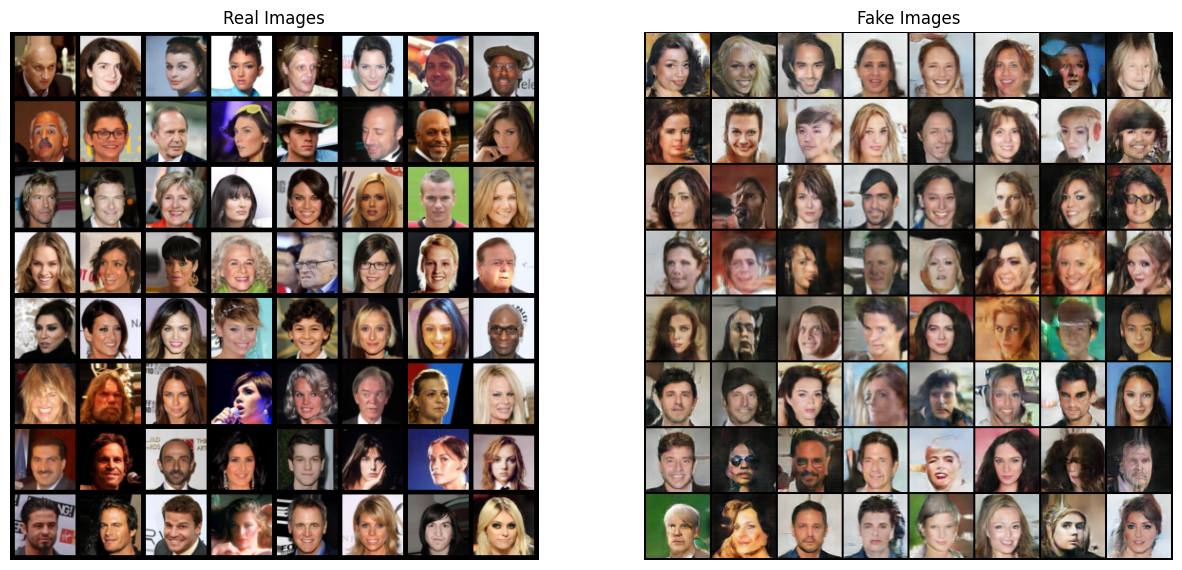

In [ ]:
# Get a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Create a figure for visualization
plt.figure(figsize=(15, 15))

# Plot Real Images
plt.subplot(1, 2, 1)  # Create subplot (1 row, 2 columns, 1st position)
plt.axis("off")  # Hide axis for better visualization
plt.title("Real Images")  # Set title
plt.imshow(np.transpose(
    vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0))
)  # Convert PyTorch tensor to NumPy format for plotting

# Plot Fake Images (Generated by Generator)
plt.subplot(1, 2, 2)  # Create subplot (1 row, 2 columns, 2nd position)
plt.axis("off")  # Hide axis
plt.title("Fake Images")  # Set title
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))  # Convert tensor to NumPy format

# Show the figure with real and fake images
plt.show()
